In [1]:
%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

Bitcoin Price Prediction
---
 Recurrent neural network model to forecast bitcoin prices/trends from 2014 to 2021.  Training data gathered obtained from Yahoo finance (https://finance.yahoo.com/quote/BTC-USD/history/) to train the recurrent neural network.

In [4]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import io
import zipfile
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
file_id = '1IvrXXUDB_kO4ydZb-lwtVF9BLccDtdJP'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('BTC-USD.csv')


In [5]:
# Create pandas dataframe
data = pd.read_csv('BTC-USD.csv')

In [6]:
# Plot data.head()
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800.0
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200.0
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700.0
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600.0
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100.0


Plotting the bitcoin price over days after September 15, 2014. Day "0" indicates September 15, 2014

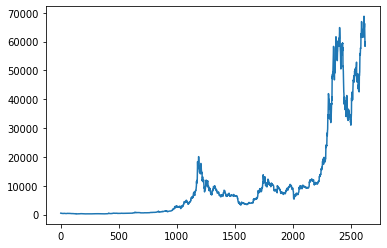

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns # Used for plotting

g = sns.lineplot(x = np.linspace(1,2622,2622), y = data['High'].values.reshape(-1))


Plotting bitcoin vs. days, where days are displayed as dates

[Text(0, 0, '2014-09-17'),
 Text(0, 0, '2015-04-05'),
 Text(0, 0, '2015-10-22'),
 Text(0, 0, '2016-05-09'),
 Text(0, 0, '2016-11-25'),
 Text(0, 0, '2017-06-13'),
 Text(0, 0, '2017-12-30'),
 Text(0, 0, '2018-07-18'),
 Text(0, 0, '2019-02-03'),
 Text(0, 0, '2019-08-22'),
 Text(0, 0, '2020-03-09'),
 Text(0, 0, '2020-09-25'),
 Text(0, 0, '2021-04-13')]

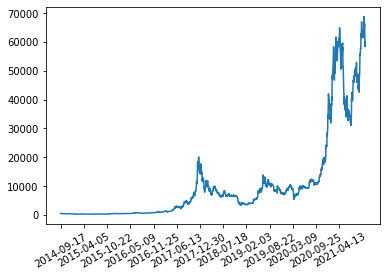

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns # Used for plotting

g = sns.lineplot(x = np.linspace(1,2622,2622), y = data['High'].values.reshape(-1))
#g.map(plt.plot, "a", "v", marker="o")
g.set(xticks=np.arange(0,2500,200))
g.set_xticklabels(rotation=30, labels = data['Date'][0::200])

In [9]:
# Creates a dataframe that only contains High Column.
data = data.dropna(subset = ['High'])
data_high = data['High'].to_numpy().reshape(-1,1)
print(data_high)

[[  468.174011]
 [  456.859985]
 [  427.834991]
 ...
 [60948.5     ]
 [58351.113281]
 [59859.878906]]


In [10]:
#using MinMaxScaler to normalize the date
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

data_normalized = scaler.fit_transform(data_high)
print(data_high.shape)

(2618, 1)


In [11]:

def create_dataset(dataset, time_steps=1):
    """
    Generate a dataset where the time series X[n] contains the readings for the 'time_step' previous days 
    and y contains the price for today.
    args:
    dataset: numpy array, the data
    time_steps: the number of previous days to feed to RNN

    returns:
    tuple: a dataset with x[i] containing 'time_step' number of previous prices, target price for x[i]
    """
    dataX, dataY = [],[]
    for i in range(len(dataset)-time_steps-1):
        a = dataset[i:(i+time_steps)]
        dataX.append(a)
        dataY.append(dataset[i + time_steps])
    return np.array(dataX), np.array(dataY)

In [12]:
# Choose the number of time steps that the model "looks back"
time_steps = 34 

X,y = create_dataset(data_normalized, time_steps)

In [13]:
#checking shape of new dataset
print(X.shape, y.shape)

(2583, 34, 1) (2583, 1)


Spliting data into train and test sets, where 80% is for training and 20% is for testing. 

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20, shuffle = False)

In [15]:
# Reshape input to be [samples, time steps, features].
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

Compile your model and display the summary:

In [16]:
#RNN Model Structure
from tensorflow.keras.layers import Embedding, Dense, Dropout, Input, LSTM, GRU
from tensorflow.keras.models import Model


input_layer = Input(shape=(1,time_steps))
x = LSTM(64)(input_layer)
x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)
# x = Dropout(0.15)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.2)(x)
print(X_train.shape, X_test.shape)
model = Model(input_layer, x)



loss = 'mean_squared_error'

opt = tf.keras.optimizers.Adam(lr = 2e-3) 

metrics = 'mean_squared_error' 

model.compile(loss= loss,
              optimizer= opt,
              metrics = metrics)

model.summary()

(2066, 1, 34) (517, 1, 34)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 34)]           0         
                                                                 
 lstm (LSTM)                 (None, 64)                25344     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
Total params: 35,744
Trainable par

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [17]:
batchsize =32 ### YOUR CODE HERE ###

epochs = 10  ### YOUR CODE HERE ###

# Fit model
history = model.fit(X_train, y_train, batch_size=batchsize, epochs=epochs, validation_split=0.2, shuffle = False) ### YOUR CODE HERE ###

Epoch 1/10
52/52 [==============================] - 6s 18ms/step - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0095 - val_mean_squared_error: 0.0095
Epoch 2/10
52/52 [==============================] - 0s 6ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0128 - val_mean_squared_error: 0.0128
Epoch 3/10
52/52 [==============================] - 0s 6ms/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0124 - val_mean_squared_error: 0.0124
Epoch 4/10
52/52 [==============================] - 0s 6ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.0105 - val_mean_squared_error: 0.0105
Epoch 5/10
52/52 [==============================] - 0s 7ms/step - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0108 - val_mean_squared_error: 0.0108
Epoch 6/10
52/52 [==============================] - 0s 6ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0083 - val_mean_squared_error: 0.0083
Epoch 7/10
52/52 [=====================

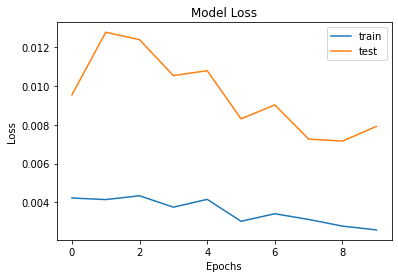

In [18]:
# Plot the Model loss

### YOUR CODE HERE ###
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

### Part d) More Advanced RNN Model (15 points)
In this part you will create an RNN model with the number of layers and architerure you prefer. Train it on your training data. You will also plot training and validation loss. Again, use mean squared error as your metric. In this part, you can try different models and use different hyper-parameters and report only the best one.

Compile your model and display the summary:

In [19]:


input_layer = Input(shape=(1,time_steps))
x = GRU(64)(input_layer)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
# x = Dense(32, activation='relu')(x)
x = Dense(1)(x)
print(X_train.shape, X_test.shape)
model = Model(input_layer, x)




loss = 'mean_squared_error'

opt = tf.keras.optimizers.Adam(2e-5)  

metrics = 'mean_squared_error' 

model.compile(loss= loss ,
              optimizer= opt,
              metrics=  metrics)

model.summary()

(2066, 1, 34) (517, 1, 34)
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1, 34)]           0         
                                                                 
 gru (GRU)                   (None, 64)                19200     
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 25,473
Trainable params: 25,473
Non-trainable params: 0
_________________________________________________________________


In [20]:
batchsize = 32
epochs =  10 

# Fit model
history = model.fit(X_train, y_train, batch_size=batchsize, epochs=epochs, validation_split=0.2, shuffle = False) 

Epoch 1/10
52/52 [==============================] - 3s 15ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 0.0120 - val_mean_squared_error: 0.0120
Epoch 2/10
52/52 [==============================] - 0s 6ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0096 - val_mean_squared_error: 0.0096
Epoch 3/10
52/52 [==============================] - 0s 6ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0076 - val_mean_squared_error: 0.0076
Epoch 4/10
52/52 [==============================] - 0s 6ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0060 - val_mean_squared_error: 0.0060
Epoch 5/10
52/52 [==============================] - 0s 6ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0048 - val_mean_squared_error: 0.0048
Epoch 6/10
52/52 [==============================] - 0s 6ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 7/10
52/52 [=====================

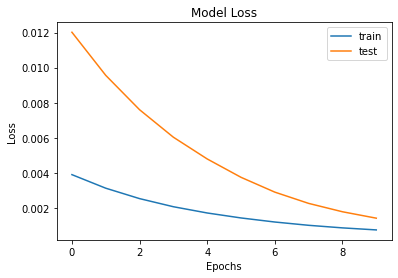

In [21]:
# Plot the Model loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

 Using the final (best) model to show model's performance on the test set. Model is trained on normalized data

517
517


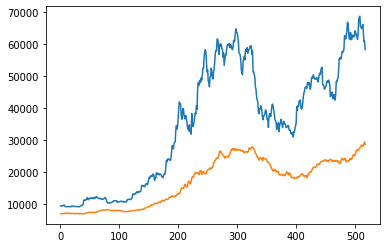

In [22]:

y_pred_test = model.predict(X_test)
y_pred_test = scaler.inverse_transform(y_pred_test)
y_Test = scaler.inverse_transform(y_test.reshape(-1,1))
print(len(y_pred_test))
print(len(y_test))


sns.lineplot(x = np.linspace(1,len(X_test),len(X_test)), y = y_Test.reshape(-1))
sns.lineplot(x = np.linspace(1,len(X_test),len(X_test)), y = y_pred_test.flatten())

# plt.plot(y_pred_test)
# plt.plot(y_Test)
# plt.show()


My model performs better with less lookup days, as it improves overall loss and causes the model to generalize better. Adding too many/increasing lookup days causes my model to overfit and worse loss. Adding more layers and dropout causes my model to have higher loss, So I added a few layers with no dropout to lower my loss. My model doesn't use Batch normalization.